In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 주식 예측 -Time Sereise : TESLA

## STEP 1 : 시계열 데이터 준비

- Tesla 주식 5년 기록

In [8]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']
print(type(ts))
print(ts.head())
df.head()


<class 'pandas.core.series.Series'>
Date
2015-08-18    260.720001
2015-08-19    255.250000
2015-08-20    242.179993
2015-08-21    230.770004
2015-08-24    218.869995
Name: Close, dtype: float64


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-08-18,255.380005,260.950012,253.559998,260.720001,260.720001,4195000
2015-08-19,260.329987,260.649994,255.020004,255.250000,255.250000,3604300
2015-08-20,252.059998,254.559998,241.899994,242.179993,242.179993,4905800
2015-08-21,236.000000,243.800003,230.509995,230.770004,230.770004,6590200
2015-08-24,202.789993,231.399994,195.000000,218.869995,218.869995,9581600


- 날짜별, 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)
- 종가(Close)로 예측

## STEP 2 : 전처리 수행


### - 결측치 확인

In [11]:
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

- 결측치 확인,  결측치가 없음 

### 그래프 확인

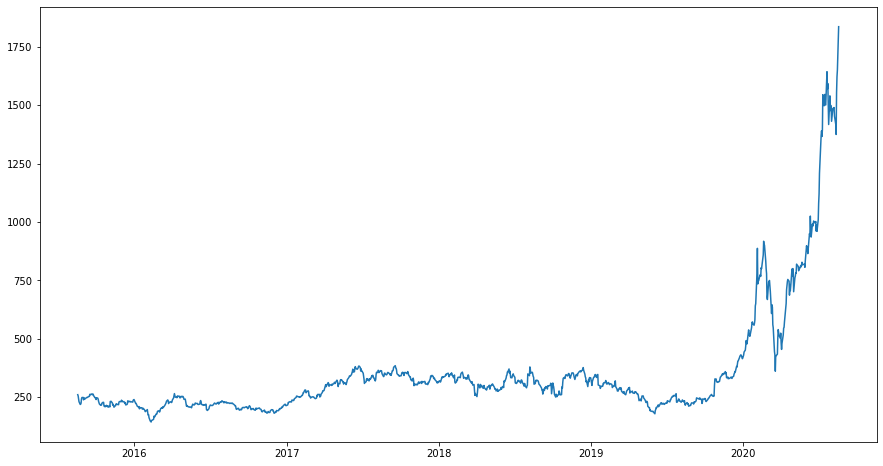

In [13]:
rcParams['figure.figsize'] = 15, 8
plt.plot(ts)

- 시계열 분석하기 괜찮은 그래프 인가? 
- 급격한 오름세... 분석가능? 

### - 로그 변환

In [15]:
ts_log = np.log(ts)

#### 로그 변환 후 그래프 
- 그래프 증폭이 전체적으로 더 확대됨 

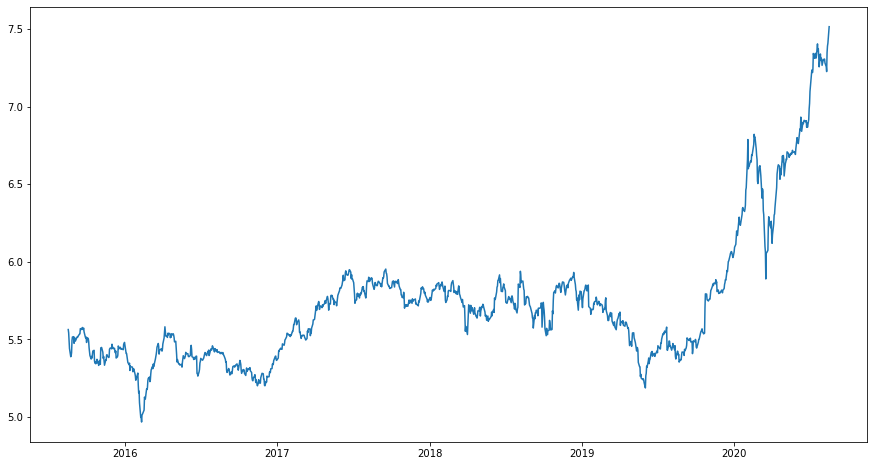

In [16]:
plt.plot(ts_log)

## STEP 3 : 시계열 안정성 분석

- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 

In [27]:
def plot_rolling_statistics(timeseries, window=60):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

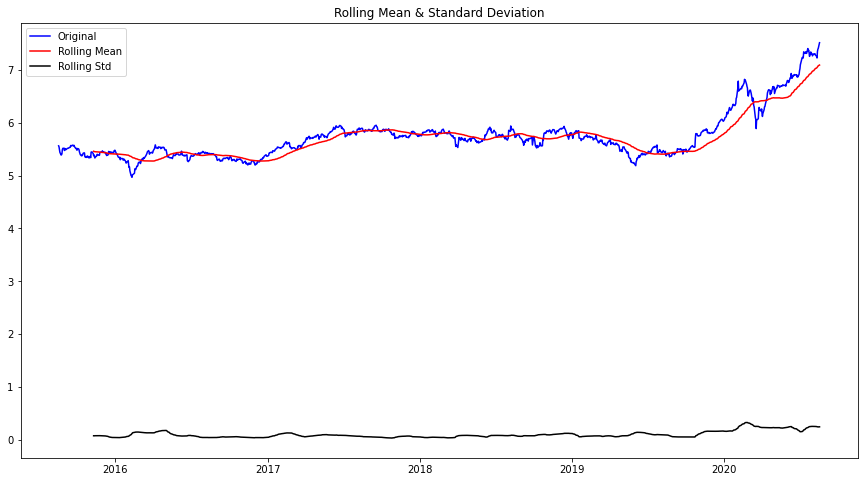

In [28]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=60)

In [29]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [31]:
#정량적 Augmented Dicky-Fuller Test
print("--------- Log 변환 전 - P- value :----------")
augmented_dickey_fuller_test(ts) 
# Log 변환 후 P-value 변화 
print("--------- Log 변환 후 - P- value :----------")
augmented_dickey_fuller_test(ts_log)

--------- Log 변환 전 - P- value :----------
Results of Dickey-Fuller Test:
Test Statistic                    5.990979
p-value                           1.000000
#Lags Used                       23.000000
Number of Observations Used    1235.000000
Critical Value (1%)              -3.435656
Critical Value (5%)              -2.863883
Critical Value (10%)             -2.568018
dtype: float64
--------- Log 변환 후 - P- value :----------
Results of Dickey-Fuller Test:
Test Statistic                    1.544276
p-value                           0.997680
#Lags Used                        0.000000
Number of Observations Used    1258.000000
Critical Value (1%)              -3.435559
Critical Value (5%)              -2.863840
Critical Value (10%)             -2.567995
dtype: float64


- "TESLA Stock data 시계열이 안정적이지 않다"는 귀무가설은 P-value가 1에 가깝게 나오고 있습니다. 
- 이 귀무가설 채택 시계열이 적합하지 않은 데이터

### 시계열 분해 (Time Series Decomposition)

In [32]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

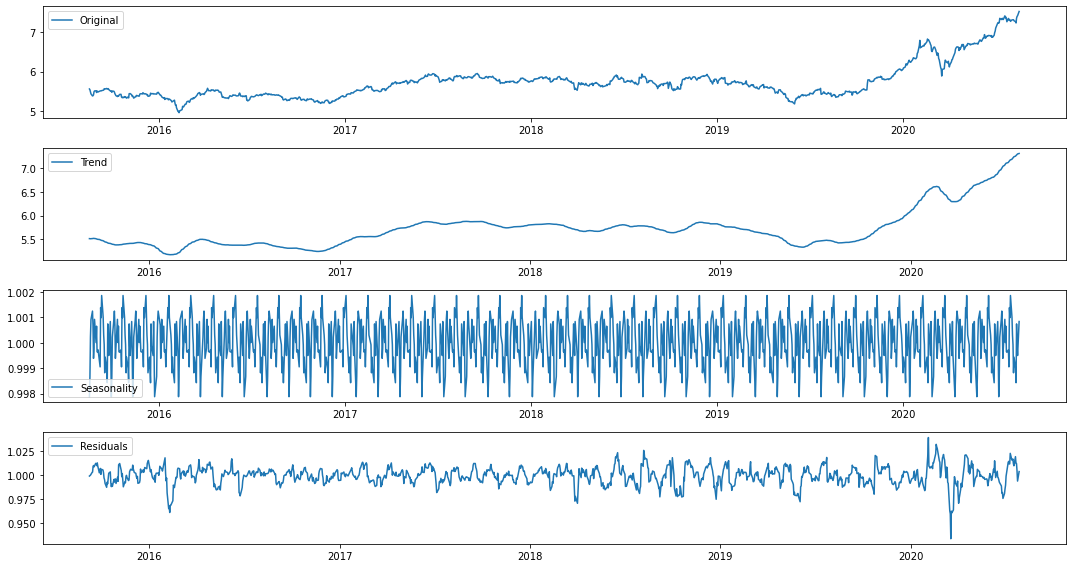

In [33]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- **Original** 시계열에서 **Trend**와 **Seasonality**를 제거하고 난 나머지를 **Residual**이라고 합니다. 
- 뒤집어서 말하면 **Trend+Seasonality+Residual=Original** 이 성립한다는 뜻입니다. 

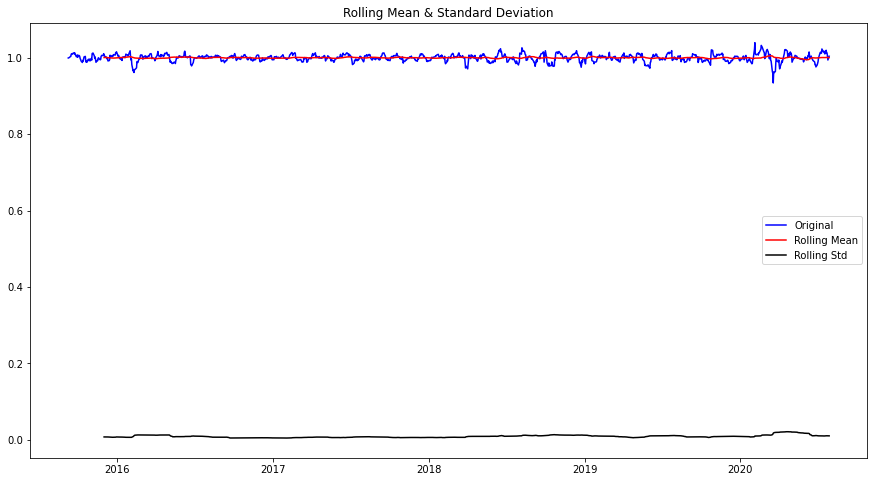

In [34]:
plot_rolling_statistics(residual)

In [35]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.181811e+01
p-value                        8.541767e-22
#Lags Used                     8.000000e+00
Number of Observations Used    1.220000e+03
Critical Value (1%)           -3.435721e+00
Critical Value (5%)           -2.863912e+00
Critical Value (10%)          -2.568033e+00
dtype: float64


- Decomposing을 통해 얻어진 Residual은 낮은 p-value를 보여 줍니다.
- 이정도면 확실히 예측가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠습니다.

## STEP 4 : 학습, 테스트 데이터셋 생성

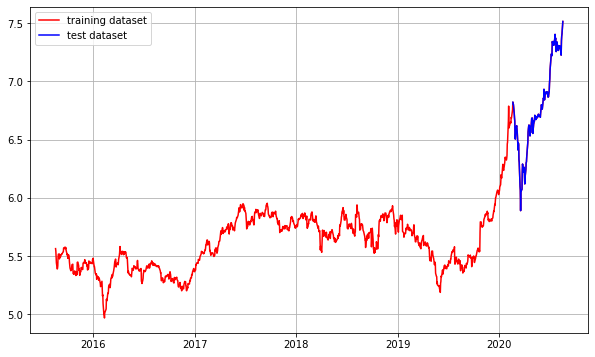

In [36]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5 : 적정 ARIMA 모수 찾기

- ACF 는 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수이며,
- PACF 는 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함수입니다.


### ACF, PACF 그려보기 -> p,q 구하기

- 자기회귀 모형(AR)의 시차를 의미하는 p

- 이동평균 모형(MA)의 시차를 의미하는 q


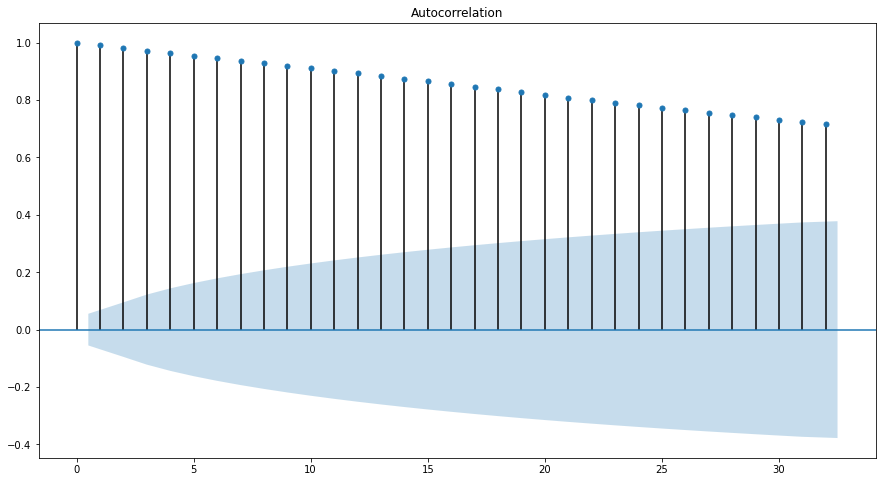

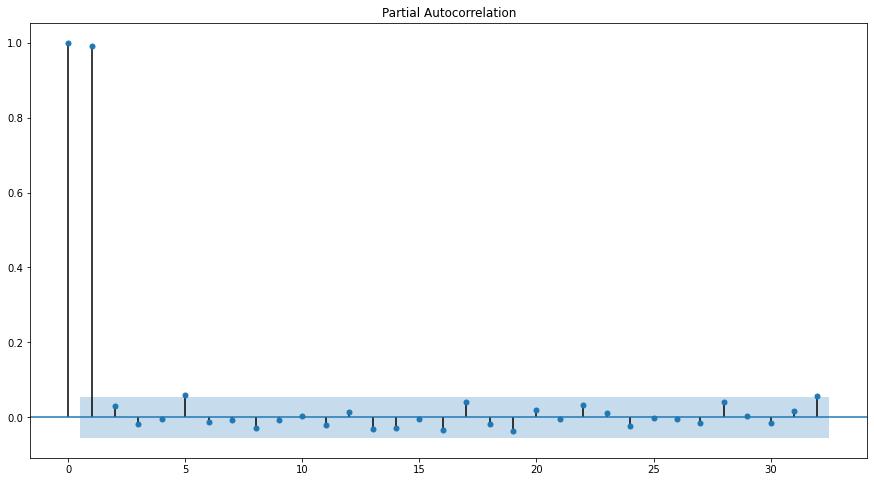

In [37]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- PACF 그래프를 보면 p = 10 적합
- p가 10 이상인 구간  PACF는 거의 0에 가깝다. 
- ACF 는 점차 감소 하고 있고 AR(1)모델 유사 
- q는 적당한 값이 없어 보인다. q = 0 

### 차분 안정성 확인 -> d 구하기


- 차분(diffdrence) 횟수를 의미하는 d

Results of Dickey-Fuller Test:
Test Statistic                -1.741868e+01
p-value                        4.839758e-30
#Lags Used                     3.000000e+00
Number of Observations Used    1.254000e+03
Critical Value (1%)           -3.435575e+00
Critical Value (5%)           -2.863848e+00
Critical Value (10%)          -2.567999e+00
dtype: float64


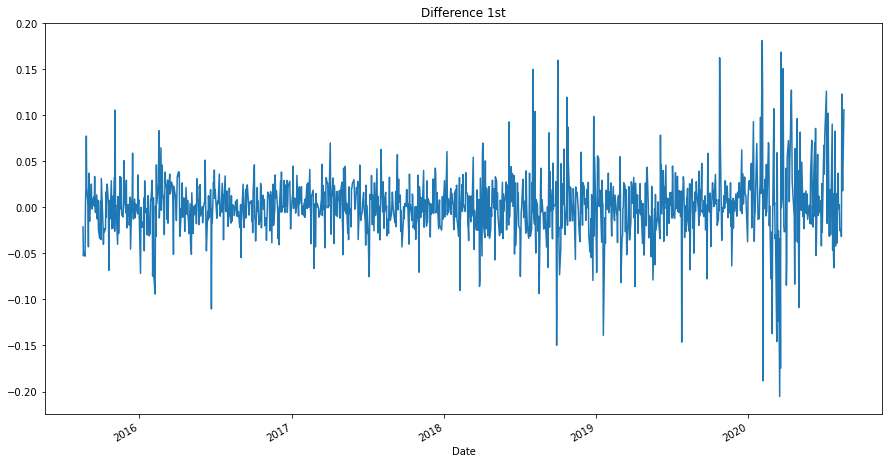

In [38]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.188182e+01
p-value                        6.152271e-22
#Lags Used                     2.300000e+01
Number of Observations Used    1.233000e+03
Critical Value (1%)           -3.435665e+00
Critical Value (5%)           -2.863887e+00
Critical Value (10%)          -2.568020e+00
dtype: float64


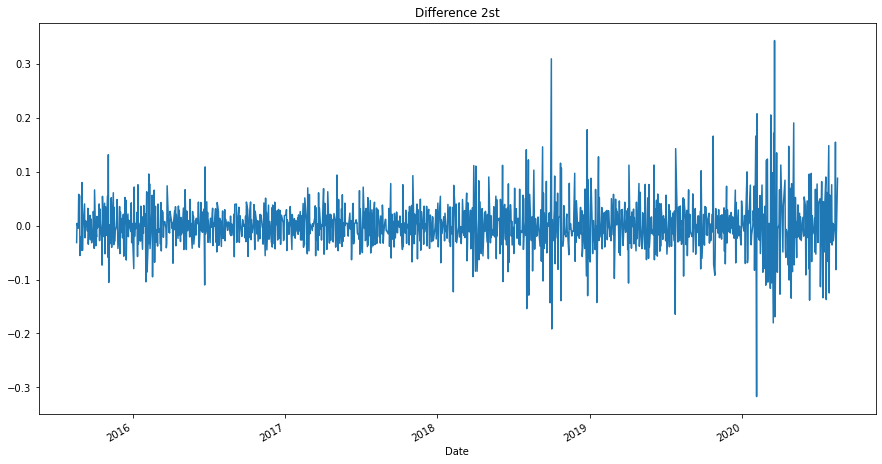

In [39]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2st')

augmented_dickey_fuller_test(diff_2)

Results of Dickey-Fuller Test:
Test Statistic                -1.481442e+01
p-value                        2.007381e-27
#Lags Used                     2.300000e+01
Number of Observations Used    1.232000e+03
Critical Value (1%)           -3.435669e+00
Critical Value (5%)           -2.863889e+00
Critical Value (10%)          -2.568021e+00
dtype: float64


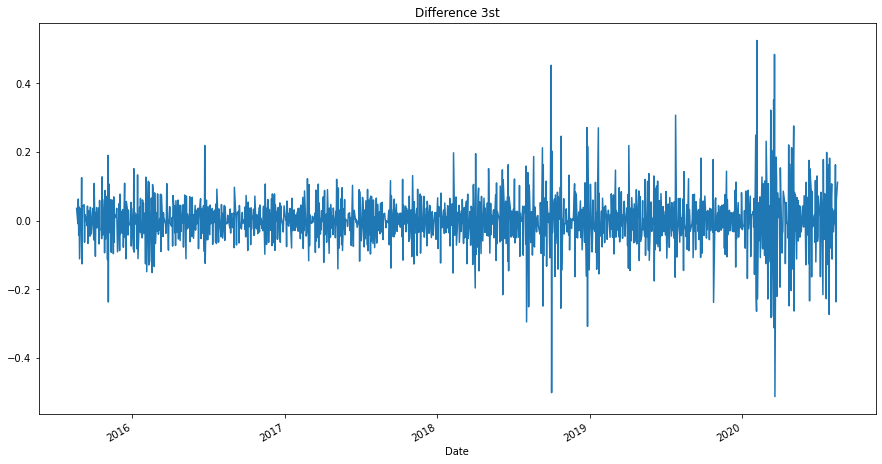

In [40]:
# 3차 차분 구하기
diff_3 = diff_2.diff(periods=1).iloc[1:]
diff_3.plot(title='Difference 3st')

augmented_dickey_fuller_test(diff_3)

- d = 2 

## STEP 6 : ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)


- p=10, d=2, q=0을 모수로 가지는 ARIMA 모델을 우선적으로 고려하게 되었습니다

In [73]:
# Build Model
model = ARIMA(train_data, order=(10, 2, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 1131
Model:                ARIMA(10, 2, 0)   Log Likelihood                2299.549
Method:                       css-mle   S.D. of innovations              0.032
Date:                Tue, 18 Aug 2020   AIC                          -4575.099
Time:                        15:07:37   BIC                          -4514.728
Sample:                             2   HQIC                         -4552.291
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.996e-05      0.000      0.186      0.852      -0.000       0.000
ar.L1.D2.Close     -0.9075      0.030    -30.499      0.000      -0.966      -0.849
ar.L2.D2.Close     -0.8050      

- 훈련데이터에 대해 ARIMA 모델이 잘 fit하는지 시각적으로 확인해 보겠습니다.

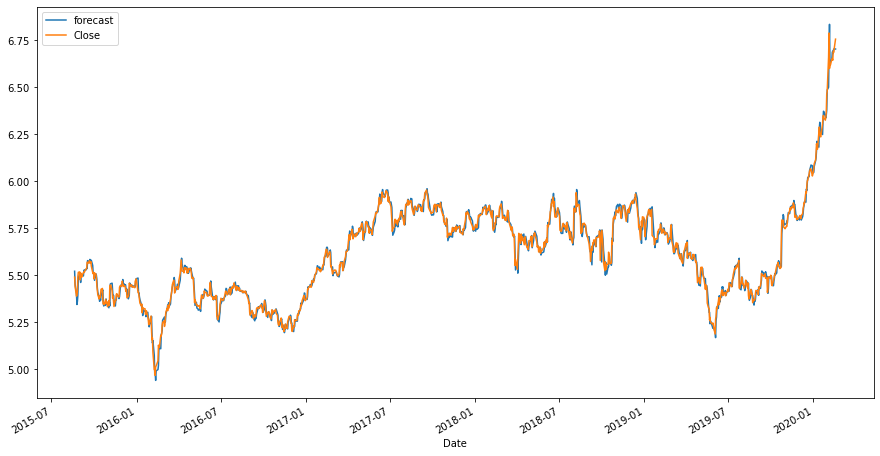

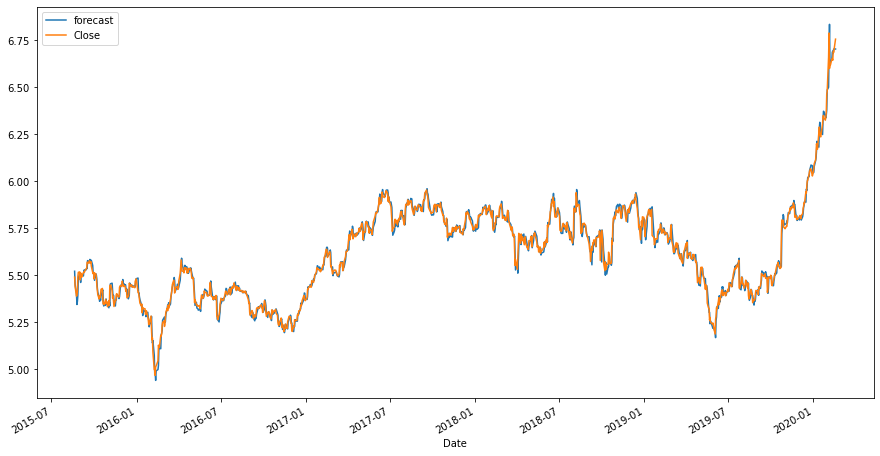

In [66]:
fitted_m.plot_predict()

### 모델 테스트 및 플로팅

####  forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측


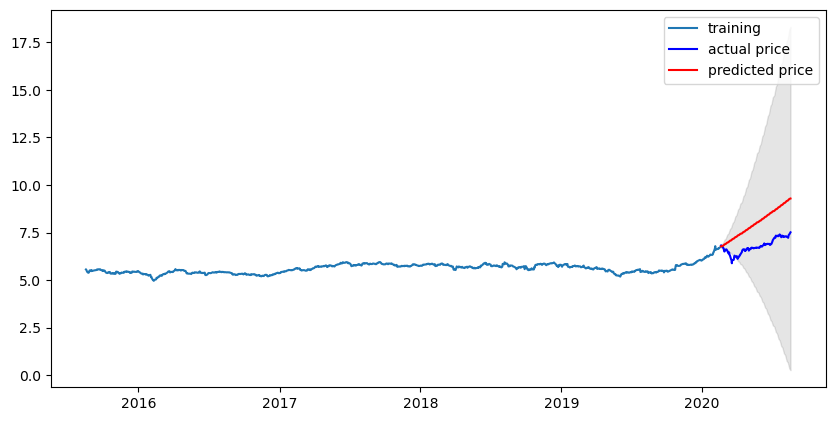

In [67]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()

### 최종 예측 모델 정확도 측정(MAPE)

In [70]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  14055484.386252506
MAE:  2872.836598895913
RMSE:  3749.0644681376853
MAPE: 265.04%


- q3일때 2000을 넘어가는 엄청난 오차율
- q= 10일때 오차율 265.04%
- 예측 망필